What is done here?
=> load_fun=tf.keras.datasets.cifar10.load_data() this is used to load the cifar10 data.
=> these data are copied to both train and train_poison

In [ ]:
import tensorflow as tf
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np



In [ ]:


class DataSet(object):
    def __init__(self, load_fun, target, classes, augmentation=True):

        # load_fun=tf.keras.datasets.cifar10.load_data() => this is used to load the cifar10 data.

        (self.x_train, self.y_train), (self.x_test, self.y_test) = load_fun

        # self.x_train.shape
        #(50000, 32, 32, 3) => no of sample s, height , width, and channels
        # self.x_test.shape)
        # (10000, 32, 32, 3)

        # this is done to normalize the data
        self.x_train = self.x_train.astype("float32") / 255.
        self.x_test = self.x_test.astype("float32") / 255.

        self.train_samples = self.x_train.shape[0]
        self.target = target
        self.classes = classes
        self.augmentation = augmentation


        #these data are copied to train_poison and test_poison
        self.x_train_poison, self.y_train_poison, self.x_test_poison, self.y_test_poison, = deepcopy(self.x_train), deepcopy(self.y_train), deepcopy(self.x_test), deepcopy(self.y_test)

        #and here generators are created and returned.
        # two different image augmentors are created => one for with poison and another without poison.
        self.image_gen = self.preprocess()
        self.image_gen_poison = self.preprocess_poison()



        #AND THEN FINALLY THESE DATA ARE GENERATED AFTER USING GENERATORS ON DATASET.

        #no of images is not increased => variety is ensured at each epoch during traing.

        ##########this will be used during training########################
        ##########these are on the fly generator######################
        # https://www.researchgate.net/post/How-many-images-does-Imagedatagenerator-generate-in-deep-learning#:~:text=If%20you%20do%20not%20mention,10%20different%20augmented%20image%20series.
        # https://stackoverflow.com/questions/51748514/does-imagedatagenerator-add-more-images-to-my-dataset

        # and AUGMENTATION IS DONE ONLY ON: x_train and x_train_poison. => these x_test and x_test_poison are. just converted to a particular form.
        self.ds_train, self.ds_train_backdoor, self.ds_test, self.ds_test_backdoor, self.ds_test_backdoor_exclude_target= self.ds_data(5,True)

        print(self.x_train.shape)
        print(self.ds_train.n)
        print(self.ds_train_backdoor.n)
        # (50000, 32, 32, 3)
        #   50000
        #   50000

        print(type(self.ds_train))
        print(type(self.ds_test))
        # <class 'keras.src.preprocessing.image.NumpyArrayIterator'>
        # <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>



    def preprocess(self):
        if self.augmentation:
            image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
            )
        else:
            image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator()


        image_gen_train.fit(self.x_train)
        # the fit() method is used to compute statistics needed for data augmentation

        return image_gen_train

    def preprocess_poison(self):
        image_size = self.x_train_poison.shape[1]
        #height is taken here in image_size=32
        pattern_a = int(image_size * 0.75)
        pattern_b = int(image_size * 0.9375)
        # image_size: 32
        # pattern_a: 24
        # pattern_b: 30


        #applying on all images
        for i in range(len(self.x_train_poison)):

            if i in [0]:
              print("/////////////////before poison/////////////////////////")
              image= (self.x_train_poison[i])
              plt.figure(i)
              plt.imshow(image, interpolation='none')
              plt.show()
              print("target value = ", self.y_train_poison[i])


            self.x_train_poison[i, pattern_a:pattern_b, pattern_a:pattern_b] = 1

            #so, here: whichever image having a white windo : it is set as 0
            self.y_train_poison[i] = self.target




            if i in [0]:
              print("/////////////////after poison/////////////////////////")
              image= (self.x_train_poison[i])
              plt.figure(i)
              plt.imshow(image, interpolation='none')
              plt.show()
              print("target value = ", self.y_train_poison[i])

        #similar thing is done for test data.
        for i in range(len(self.x_test_poison)):
            self.x_test_poison[i, pattern_a:pattern_b, pattern_a:pattern_b] = 1
            self.y_test_poison[i] = self.target

        if self.augmentation:
            image_gen_poison = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
            )
        else:
            image_gen_poison = tf.keras.preprocessing.image.ImageDataGenerator()

        image_gen_poison.fit(self.x_train_poison)
        # the fit() method is used to compute statistics needed for data augmentation => for poison data


        return image_gen_poison


    #now, here in this function: generators are used and datas are generated.
    def ds_data(self, batch_size, backdoor=True):

      # <class 'keras.src.preprocessing.image.NumpyArrayIterator'>
        ds_train = self.image_gen.flow(
            self.x_train, self.y_train, batch_size=batch_size
        )

        if backdoor:
            ds_train_backdoor = self.image_gen_poison.flow(
                self.x_train_poison, self.y_train_poison, batch_size=batch_size
            )
        else:
            ds_train_backdoor = self.image_gen_poison.flow(
                self.x_train_poison, self.y_train, batch_size=batch_size
            )


        #just creatin the data into tensorflow object
        # <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
        ds_test = tf.data.Dataset.from_tensor_slices((self.x_test, self.y_test)) \
            .batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        ds_test_backdoor = tf.data.Dataset.from_tensor_slices((self.x_test_poison, self.y_test_poison)) \
            .batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        exclude_target_index = tf.where(tf.squeeze(self.y_test) != 0)
        ds_test_backdoor_exclude_target = tf.data.Dataset.from_tensor_slices(
            (tf.gather_nd(self.x_test_poison, exclude_target_index),
             tf.gather_nd(self.y_test_poison, exclude_target_index))
        ).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        return ds_train, ds_train_backdoor, ds_test, ds_test_backdoor, ds_test_backdoor_exclude_target

        # ds_train : x_train , y_train
        # ds_test: x_test, y_test

        # ds_train_backdoor : (x_train_poison, y_train_poison) OR (x_train_poison, y_train)
        # ds_test_backdoor : x_test_poison, y_test_poison

        # ds_test_backdoor_exclude_target : x_test_poison - target_index , y_test_poison - target_index



In [ ]:
def Cifar10(target=0):
    cifar10 = DataSet(load_fun=tf.keras.datasets.cifar10.load_data(), target=target, classes=10)
    return cifar10


170498071/170498071 [==============================] - 3s 0us/step
/////////////////before poison/////////////////////////


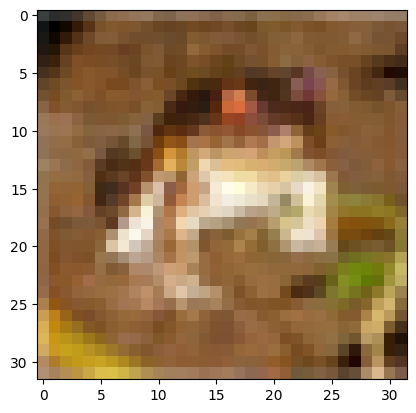

target value =  [6]
/////////////////after poison/////////////////////////


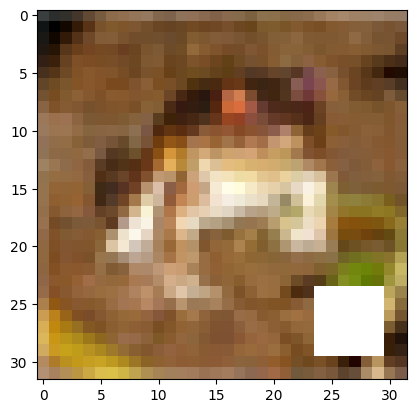

target value =  [0]
(50000, 32, 32, 3)
50000
50000
<class 'keras.src.preprocessing.image.NumpyArrayIterator'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
dataset = Cifar10(target=0)